# What you will Learn
NLP is one of the most important areas of data science. This notebook focuses on the detection of `Fake News`. Most people tend to use deep learning approaches based on word embeddings, word sequences and other elaborate methods to detect them. In this notebook you will learn, that you can already achieve extremely good results by focusing on easily extracted features. Even though these methods are far from perfect, they are easy to perform and they allow us to get some valuable insights into the structure of Fake News.

<div class="alert alert-danger" role="alert">
    <h3>This notebook is work in progress. Feel free to <span style="color:red">comment</span> if you have any suggestions   |   motivate me with an <span style="color:red">upvote</span> if you like this project.</h3>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS
import nltk
import string
import seaborn as sns

In [2]:
import pandas as pd
import io
from google.colab import files

In [3]:
import nltk

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Get an overview of both CSVs and merge them together!
The data is provided in two separated csv files. One file contains real articles, the other file contains fake news. Let's get an idea of both files.

In [6]:
fnn_train = pd.read_csv('/content/gdrive/MyDrive/fake news detection(FakeNewsNet)/fnn_train.csv')
fnn_test = pd.read_csv('/content/gdrive/MyDrive/fake news detection(FakeNewsNet)/fnn_test.csv')

## Let's take a look at Real News

In [ ]:
fnn_train.head()

id  ... label_fnn
0  3106  ...      fake
1  5655  ...      fake
2  3506  ...      fake
3  3450  ...      real
4  4776  ...      fake

[5 rows x 8 columns]

are there any missing values in `News.csv`?

In [ ]:
fnn_test.isna().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

not a single column contains missing values!

Which `subjects` are contained in this file?

## Let's take a look at Fake News

In [ ]:
fnn_test.head()

id  ... label_fnn
0  1678  ...      real
1  1820  ...      real
2  1624  ...      real
3  1576  ...      real
4  1770  ...      real

[5 rows x 8 columns]

are there any missing values in `Fake.csv`?

In [ ]:
fnn_test.isna().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

In [10]:
fnn_train = fnn_train.replace(to_replace ="fake",
                 value =1)
fnn_train = fnn_train.replace(to_replace ="real",
                 value =0)

In [ ]:
fnn_test = fnn_test.replace(to_replace ="fake",
                 value =1)
fnn_test = fnn_test.replace(to_replace ="real",
                 value =0)

In [11]:
fnn_train = fnn_train.drop(['id','date', 'speaker', 'sources','paragraph_based_content'], axis=1)
fnn_test = fnn_test.drop(['id','date', 'speaker', 'sources','paragraph_based_content'], axis=1)


In [12]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

For this notebook, I will ignore the `dates` and `subjects`(because they are disjoint). I will probably take a look at them in a later project. Let's drop them for now.

In [13]:
fnn_train.duplicated().sum()

0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


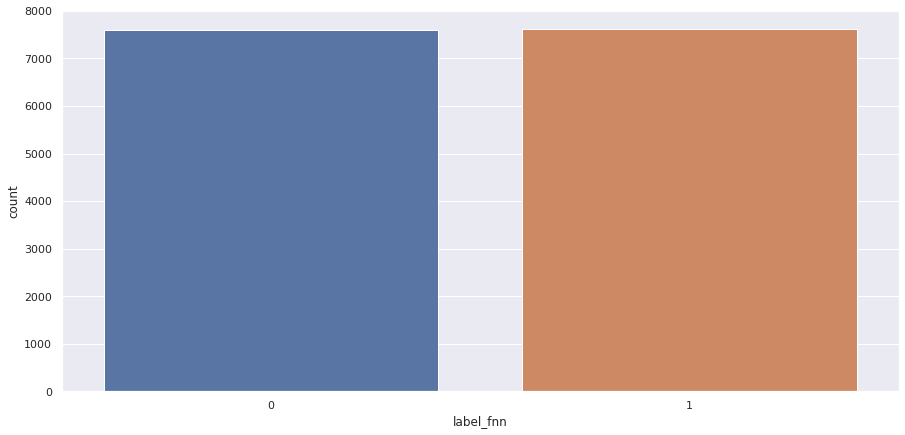

In [ ]:
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.countplot(fnn_train['label_fnn'])

Before taking a closer look at the data, perform a `train_test_split` to evade **Data Snooping**!

In [14]:
X_train = fnn_train.drop('label_fnn', axis=1)
y_train = fnn_train['label_fnn']
X_test = fnn_test.drop('label_fnn', axis=1)
y_test = fnn_test['label_fnn']

In [ ]:
y_train.value_counts()

1    7621
0    7591
Name: label_fnn, dtype: int64

In [ ]:
y_test.value_counts()

0    636
1    418
Name: label_fnn, dtype: int64

# Inspect the Training data to get further insights
Therefore we have to split the Training set into News and Fake News

In [48]:
train_news = X_train.loc[(y_train==0),:]
train_fake = X_train.loc[(y_train==1),:]

## Lexical Diversity of Fake News
Let's define a measure for lexical diversity to find out how many unique vocabs are used in Fake News articles.

Let's define the lexical diversity measure as $\frac{\text{number of unique words in one (target)category}}{\text{number of words in both (target)categories}}$

In [49]:
# a very simple measure for lexical diversity
def lexical_diversity(data, other_data, feature):
    # ignoare capital letters
    column = data[feature].str.lower() 
    # create one text from the column
    text = ' '.join(column)
    # drop punctuation
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    # create a list of wordsw instead of one huge text
    words_splitted = words.split()
    
    # analogously
    other_column = other_data[feature].str.lower() 
    other_text = ' '.join(other_column)
    other_words = ''.join(char for char in other_text if char not in exclude)
    other_words_splitted = other_words.split()
    # lexical diversity measure
    return len(set(words_splitted)) / (len(words_splitted) + len(other_words_splitted))

print(f'Real News: {lexical_diversity(data=train_news, other_data=train_fake, feature="fullText_based_content")}')
print(f'Fake News: {lexical_diversity(data=train_fake, other_data=train_news, feature="fullText_based_content")}')

Real News: 0.007032045585307679
Fake News: 0.0071569756919777315


Interestingly it seems like `Fake News` contain almost two times greater lexical diversity than real news. Their authors seem to have a wide vocabulary.

## Most frequently used words in Titles
is there a difference between the most frequently used words in the titles of Real News and Fake News? This question might already reveal the topics of the Fake News articles.

In [50]:
stopwords = set(STOPWORDS)

def common_tokens_title(data, feature, name):
    column = data[feature].str.lower() 
    text = ' '.join(column)
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    words_splitted = words.split()
    words_stopped = [word for word in words_splitted if not word in stopwords]
    print(f'{name}:\n{pd.DataFrame(nltk.FreqDist(words_stopped).most_common(10))[0]}')
    
common_tokens_title(train_news, 'statement', 'Most common descriptive words in Real News Titles')
print('\n')
common_tokens_title(train_fake, 'statement', 'Most common descriptive words in Fake News Titles')

Most common descriptive words in Real News Titles:
0       says
1    percent
2      state
3     people
4        tax
5      years
6       year
7    million
8     states
9     health
Name: 0, dtype: object


Most common descriptive words in Fake News Titles:
0         says
1    president
2        obama
3      percent
4       people
5          tax
6       health
7        state
8         will
9         care
Name: 0, dtype: object


It seems like most Fake News Articles in our Training data are about US Presidents and candidates for the latter. Besides `trump`, the real news seem to focus on more general political topics.

# Punctutation
Punctuation might provide some information for predictions. 

In [51]:
import regex as re

# let's begin with a helper function to count punctuation
def count_punctuation(text):
    peri = re.subn(r"\.", '', text)[1]
    comm = re.subn(r"\,", '', text)[1]
    ques = re.subn(r"\?", '', text)[1]
    excl = re.subn(r"\!", '', text)[1]
    return [peri,comm, ques, excl]
    
count_punctuation('...alph!a.beta.gamma...??')

[8, 0, 2, 1]

In [52]:
# count the usage of puntuations per row in a specified feature (title and text)
# and store the data in a dataframe
def create_punctuation_df(dataset, feature):
    return dataset.apply(lambda row: pd.Series({'peri_' + feature:count_punctuation(row[feature])[0], 
                                                       'comm_' + feature:count_punctuation(row[feature])[1],
                                                      'ques_' + feature:count_punctuation(row[feature])[2],
                                                      'excl_' + feature:count_punctuation(row[feature])[3]}), axis=1)

punctuation_train_title = create_punctuation_df(fnn_train, 'statement')
punctuation_test_title = create_punctuation_df(fnn_test, 'statement')
punctuation_train_text = create_punctuation_df(fnn_train, 'fullText_based_content')
punctuation_test_text = create_punctuation_df(fnn_test, 'fullText_based_content')
punctuation_train_text 

peri_fullText_based_content  ...  excl_fullText_based_content
0                               44  ...                            0
1                               55  ...                            0
2                               35  ...                            0
3                               58  ...                            0
4                               31  ...                            1
...                            ...  ...                          ...
15207                           71  ...                            0
15208                           30  ...                            0
15209                           26  ...                            1
15210                           73  ...                            0
15211                           49  ...                            0

[15212 rows x 4 columns]

# Text Length

In [53]:
# count the text length per row for both features (title and text)
# and store the information in a dataframe
def create_len_df(dataset):
    return dataset.apply(lambda row: pd.Series({'length_title':len(row['statement']),
                                               'length_text':len(row['fullText_based_content'])}), axis=1)

len_train = create_len_df(fnn_train)
len_test = create_len_df(fnn_test)
len_train

length_title  length_text
0                79         4339
1                74         5930
2               160         4509
3               280         7094
4               245         3694
...             ...          ...
15207            71         5281
15208            85         3528
15209           216         2508
15210           174         9027
15211           138         5912

[15212 rows x 2 columns]

## Number of Words in the Title
Let's create a feature which counts the number of words in the Title. In my **Digital Markeeting Courses** I learned, that titles are extremely important when it comes to grabbing Attention. A rule of thumbs tells us that titles should have about 5 words.

In [54]:
def create_num_words_df(dataset):
    return dataset.apply(lambda row: pd.Series({'num_words_title':len(row['statement'].split())}), axis=1)

num_words_train = create_num_words_df(fnn_train)
num_words_test = create_num_words_df(fnn_test)

num_words_train

num_words_title
0                   12
1                   12
2                   26
3                   46
4                   40
...                ...
15207               10
15208               14
15209               37
15210               24
15211               26

[15212 rows x 1 columns]

## Lenght of Title Relative to the Length of the Article + Title
One could assume that some attention grabbing Fake News have a long title and very short texts. Is that true?

In [55]:
def create_title_ratio_df(dataset):
    return dataset.apply(lambda row: pd.Series({'title_ratio':len(row['statement'])/(len(row['statement']) + len(row['fullText_based_content']))}), axis=1)

title_ratio_train = create_title_ratio_df(fnn_train)
title_ratio_test = create_title_ratio_df(fnn_test)

title_ratio_train

title_ratio
0         0.017881
1         0.012325
2         0.034269
3         0.037971
4         0.062199
...            ...
15207     0.013266
15208     0.023526
15209     0.079295
15210     0.018911
15211     0.022810

[15212 rows x 1 columns]

## Concatenate the new Datasets

In [56]:
X_train_punct_len = pd.concat([punctuation_train_title, 
                               punctuation_train_text, 
                               len_train, 
                               num_words_train, 
                               title_ratio_train], 
                              axis=1)

X_test_punct_len = pd.concat([punctuation_test_title, 
                              punctuation_test_text, 
                              len_test, 
                              num_words_test, 
                              title_ratio_test], 
                             axis=1)

X_train_punct_len

peri_statement  comm_statement  ...  num_words_title  title_ratio
0                   1               0  ...               12     0.017881
1                   1               0  ...               12     0.012325
2                   1               1  ...               26     0.034269
3                   3               1  ...               46     0.037971
4                   1               1  ...               40     0.062199
...               ...             ...  ...              ...          ...
15207               1               0  ...               10     0.013266
15208               1               1  ...               14     0.023526
15209               3               1  ...               37     0.079295
15210               1               1  ...               24     0.018911
15211               1               2  ...               26     0.022810

[15212 rows x 12 columns]

## **Let's clean the data and add sentiment features**




In [43]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [44]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [46]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Data Cleaning and Sentiment Analyze

In [ ]:
X_sentiment_train = X_train
X_sentiment_test = X_test

In [ ]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
        # join all
    text = " ".join(text)
    return(text)

# clean text data
X_sentiment_train['fullText_based_content'] = X_sentiment_train['fullText_based_content'].apply(lambda x: clean_text(x))
X_sentiment_test['fullText_based_content'] = X_sentiment_test['fullText_based_content'].apply(lambda x: clean_text(x))

In [ ]:
X_sentiment_train['fullText_based_content']

0        coalition government watchdog group last week ...
1        supreme court justice embark three day oral ar...
2        here's new one senate budget committee chairma...
3        recently house budget chairman paul ryan r-wis...
4        millionaires’ tax proposal make late appearanc...
                               ...                        
15207    legislation file week u.s sen john cornyn tout...
15208    sen bernie sander argue former vice president ...
15209    ready billionaire talk recent facebook post la...
15210    know labor union stand republican gov scott wa...
15211    outline education platform may former vice pre...
Name: fullText_based_content, Length: 15212, dtype: object

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = X_sentiment_train['fullText_based_content'].apply(lambda x: sid.polarity_scores(x))
sent_scores_train = pd.DataFrame(list(sentiment_scores))

sid = SentimentIntensityAnalyzer()
sentiment_scores = X_sentiment_test['fullText_based_content'].apply(lambda x: sid.polarity_scores(x))
sent_scores_test = pd.DataFrame(list(sentiment_scores))

In [ ]:
sent_scores_train.head()

neg    neu    pos  compound
0  0.114  0.786  0.100   -0.8381
1  0.086  0.811  0.103    0.8703
2  0.022  0.940  0.038    0.6351
3  0.138  0.778  0.084   -0.9912
4  0.050  0.877  0.072    0.7295

In [ ]:
sent_scores_train.index = X_train_punct_len.index
sent_scores_test.index = X_test_punct_len.index

In [ ]:
sent_scores_train

neg    neu    pos  compound
0      0.114  0.786  0.100   -0.8381
1      0.086  0.811  0.103    0.8703
2      0.022  0.940  0.038    0.6351
3      0.138  0.778  0.084   -0.9912
4      0.050  0.877  0.072    0.7295
...      ...    ...    ...       ...
15207  0.096  0.837  0.068   -0.9723
15208  0.129  0.700  0.171    0.9524
15209  0.147  0.756  0.097   -0.9407
15210  0.105  0.740  0.155    0.9960
15211  0.064  0.752  0.184    0.9965

[15212 rows x 4 columns]

In [ ]:
X_train_punct_len['negative'] = sent_scores_train['neg'].values
X_train_punct_len['positive'] = sent_scores_train['pos'].values
X_train_punct_len['neutral'] = sent_scores_train['neu'].values


X_test_punct_len['negative'] = sent_scores_test['neg'].values
X_test_punct_len['positive'] = sent_scores_test['pos'].values
X_test_punct_len['neutral'] = sent_scores_test['neu'].values

# Random Forest
Let's use a default RandomForest for our classification!

In [ ]:

from sklearn.ensemble import RandomForestClassifier
# Train the model
rf = RandomForestClassifier()
rf.fit(X_train_punct_len, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds_test = rf.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.7296587926509187
acc: 0.73989898989899


In [ ]:
confusion_matrix(y_test, preds_test)

array([[620, 198],
       [208, 558]])

# Investigate the Engineered Features

In [ ]:
X_train_punct_len.head()

peri_statement  comm_statement  ques_statement  ...  negative  positive  neutral
0               1               0               0  ...     0.114     0.100    0.786
1               1               0               0  ...     0.086     0.103    0.811
2               1               1               0  ...     0.022     0.038    0.940
3               3               1               0  ...     0.138     0.084    0.778
4               1               1               0  ...     0.050     0.072    0.877

[5 rows x 15 columns]

* Many Titles don't contain any form of `punctuation`!

* Some texts contain suspiciously small amounts of characters. At least one of them contains only 1 chars

Let's remove some extreme outliers!

In [ ]:
from scipy import stats
X_train_punct_len_zscore = X_train_punct_len.apply(stats.zscore, axis=0)
mask_outliers = np.logical_not(((X_train_punct_len_zscore>5).any(axis=1)).values + ((X_train_punct_len_zscore<-5).any(axis=1)).values)
X_train_punct_len = X_train_punct_len.loc[mask_outliers,:]
y_train = y_train[X_train_punct_len.index]

How does our data look like now?

In [ ]:
X_train_punct_len.describe()

peri_statement  comm_statement  ...      positive       neutral
count    14685.000000    14685.000000  ...  14685.000000  14685.000000
mean         1.378618        0.607354  ...      0.118682      0.788700
std          0.892052        0.921238  ...      0.048505      0.071229
min          0.000000        0.000000  ...      0.000000      0.473000
25%          1.000000        0.000000  ...      0.084000      0.744000
50%          1.000000        0.000000  ...      0.113000      0.794000
75%          1.000000        1.000000  ...      0.147000      0.839000
max          6.000000        5.000000  ...      0.345000      0.997000

[8 rows x 15 columns]

## How do they interact with each other?

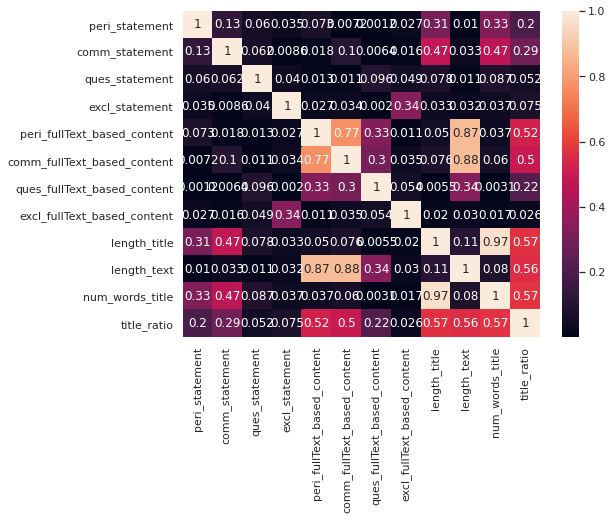

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(np.abs(X_train_punct_len.corr()), annot=True)
plt.savefig('correlation')
plt.show()

* huge correlation between `peri_text` and `length_text`

* huge correlation between `comm_text` and `length_text`

* huge correlation between `comm_text` and `peri_text`

* huge correlation between `peri_test` and `num_words_text`

...and so on

We have to find out how they interact with the target to determine what to do with them.

## How do they Interact with the Target?

In [ ]:
pd.concat([X_train_punct_len, y_train], axis=1).groupby('label_fnn').mean()

peri_statement  comm_statement  ...  positive   neutral
label_fnn                                  ...                    
0                1.390418        0.664238  ...  0.120180  0.789994
1                1.366598        0.549416  ...  0.117155  0.787383

[2 rows x 15 columns]

**Main Findings:**
* Titles of Fake News contain ~4 times less `periods`

* Titles of Fake News contain ~10 times more `question marks`

* Titles of Fake News contain ~130 times more `exclamation marks` **(wow!)**

* Texts of Fake News contain ~10 times more `question marks` 

* Texts of Fake News contain ~10 times more `exclamation marks`

* Titles of Fake News are 50% `longer`. The number of words seems to reflect that fact as well. -> The length of words in the titles of Fake News and real News don't seem to vary a lot.

* $\frac{len(title)}{len(title) + len(text)}$ is ~40% longer in Fake News

* Let's ignore the high correlations we found above. A more elaborate approach would be to eliminate correlating features by dropping them or using dimensionality reduction like PCA

# Apply Naive Bayes( ACC: 54.1%)

In [57]:
# Naive Bayes Model
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [58]:
nb = MultinomialNB()
nb.fit(X_train_punct_len, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [61]:
preds_test = nb.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

TypeError: ignored

In [ ]:
confusion_matrix(y_test, preds_test)

array([[418, 218],
       [265, 153]])

# Logistic Regression ( 62.7%)

In [62]:
from sklearn.linear_model import LogisticRegression

# Train the model
lr = LogisticRegression()
lr.fit(X_train_punct_len, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
preds_test = lr.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

TypeError: ignored

In [ ]:
confusion_matrix(y_test, preds_test)

array([[362, 274],
       [118, 300]])

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, preds_test, labels=[0, 1]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, preds_test, labels=[0, 1]))

[[362 274]
 [118 300]]
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       636
           1       0.52      0.72      0.60       418

    accuracy                           0.63      1054
   macro avg       0.64      0.64      0.63      1054
weighted avg       0.66      0.63      0.63      1054



# Random Forest
Let's use a default RandomForest for our classification!

In [ ]:

from sklearn.ensemble import RandomForestClassifier
# Train the model
rf = RandomForestClassifier()
rf.fit(X_train_punct_len, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
preds_test = rf.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.6434262948207172
acc: 0.6603415559772297


In [ ]:
confusion_matrix(y_test, preds_test)

array([[620, 198],
       [208, 558]])

# A Simple Model based on Punctuation and Text Length
Let's use a default RandomForest for our classification!

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
preds = cross_val_predict(rf, X_train_punct_len, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.5247817617776496
acc: 0.5514470548178413


These are already pretty nice results on train! What are the most `important features`?

In [ ]:
rf.fit(X_train_punct_len, y_train)
pd.Series(rf.feature_importances_, 
          index=X_train_punct_len.columns).sort_values(ascending=False)

length_text                    0.114549
title_ratio                    0.110933
negative                       0.107348
neutral                        0.103861
positive                       0.102483
comm_fullText_based_content    0.098557
length_title                   0.095201
peri_fullText_based_content    0.091620
num_words_title                0.069342
ques_fullText_based_content    0.043934
peri_statement                 0.026041
comm_statement                 0.022689
excl_fullText_based_content    0.013443
excl_statement                 0.000000
ques_statement                 0.000000
dtype: float64

Interestingly, the length of the title is way more important than e.g. `excl_title`, even though the relation between the target and `excl_title` is way stronger. This is most likely the case because only a few titles contain exclamation marks.

## Finetune the model

In [ ]:
from sklearn.model_selection import GridSearchCV
params= {'n_estimators':[200, 300],
        'criterion':['gini', 'entropy'],
        'max_depth':[5, None],
        'max_features':[2,5]}
gscv = GridSearchCV(rf, params)
gscv.fit(X_train_punct_len, y_train)
gscv.best_params_

{'criterion': 'gini', 'max_depth': 5, 'max_features': 2, 'n_estimators': 300}

In [ ]:
rf_tuned = RandomForestClassifier(criterion='entropy', max_depth=None, max_features=2, n_estimators=200, random_state=42)
preds = cross_val_predict(rf_tuned, X_train_punct_len, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.5285549759501389
acc: 0.5425322114120431


In [ ]:
rf_tuned.fit(X_train_punct_len, y_train)
pd.Series(rf_tuned.feature_importances_, 
          index=X_train_punct_len.columns).sort_values(ascending=False)

length_title       0.251087
num_words_title    0.164880
ques_text          0.090958
title_ratio        0.087228
length_text        0.072706
peri_text          0.047101
comm_text          0.046114
excl_text          0.044855
positive           0.041755
neutral            0.041711
negative           0.040827
peri_title         0.036661
excl_title         0.024308
comm_title         0.009810
ques_title         0.000000
dtype: float64

# How well can we predict on subsets of the Features?

In [ ]:
forest = RandomForestClassifier(random_state=42)

best_column = 'all'
best_score = 0
for column in X_train_punct_len.columns:
    forest.fit(X_train_punct_len[column].values.reshape((-1,1)), y_train)
    preds = cross_val_predict(forest, X_train_punct_len[column].values.reshape((-1,1)), y_train, cv=5)
    f1 = f1_score(y_true=y_train, y_pred=preds)
    
    if(f1>best_score):
        best_score = f1
        best_column = column

print(f'A default RandomForest already obtains an f1-score of {f1} on validation data when trained solely on the column {column}')

A default RandomForest already obtains an f1-score of 0.38525014949172814 on validation data when trained solely on the column neutral


In [ ]:
forest = RandomForestClassifier(random_state=42)
punctuation = ['peri_title', 'comm_title', 'ques_title', 'excl_title', 'peri_text', 'comm_text', 'ques_text', 'excl_text']
lenght = ['length_title', 'length_text','num_words_title', 'title_ratio']


forest.fit(X_train_punct_len[punctuation], y_train)
preds = cross_val_predict(forest, X_train_punct_len[punctuation], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on punctuation-based Features')
print('The Feature Inportances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=punctuation).sort_values(ascending=False))

forest.fit(X_train_punct_len[lenght], y_train)
preds = cross_val_predict(forest, X_train_punct_len[lenght], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on length-based Features')
print('The Feature Importances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=lenght).sort_values(ascending=False))

A default RandomForest already obtains an f1-score of 0.7467359208794336 when trained solely on punctuation-based Features
The Feature Inportances in that approach are:
ques_text     0.280368
comm_text     0.209380
peri_text     0.205038
excl_text     0.129412
peri_title    0.087740
excl_title    0.074116
comm_title    0.013946
ques_title    0.000000
dtype: float64
A default RandomForest already obtains an f1-score of 0.8499982896042144 when trained solely on length-based Features
The Feature Importances in that approach are:
length_title       0.404039
title_ratio        0.208556
length_text        0.197260
num_words_title    0.190145
dtype: float64


As we saw, even some basic feature engineering might reveal powerful features for our machine learning models. I am pretty sure that adding `Word Embeddings` will improve the performance by a lot.

Thank you for reading this notebook!